## Group Project - Checkpoint 2

### Data Cleanup Script/Visualizations

Team: Initech TPS Report Automation 

Members: Jamie Moore, Kathleen Sorensen, and Chris Wagner


## Dependencies

In [498]:
! pip install --user nltk textblob
! python -m nltk.downloader stopwords
! python -m textblob.download_corpora

! pip install numpy
import numpy as np

C:\ProgramData\Anaconda3\lib\runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to C:\Users\Jamie
[nltk_data]     MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Finished.


[nltk_data] Downloading package brown to C:\Users\Jamie
[nltk_data]     MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Jamie
[nltk_data]     MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Jamie
[nltk_data]     MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Jamie MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to C:\Users\Jamie
[nltk_data]     MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to C:\Users\Jamie
[nltk_data]     MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_review

In [499]:
! pip install wordcloud

In [500]:
import pandas as pd
import re
from stop_words import stop_words
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize



In [501]:
from wordcloud import WordCloud   #used for the word cloud visualization

In [502]:
from IPython.display import Image                   # image display
from ipywidgets import widgets, interactive, Layout # interactive visualization 
import matplotlib.pyplot as plt                     # visualization

from collections import Counter              # word counting
import nltk                                  # text processing
from textblob import TextBlob                # sentiment analysis and language detection and translation 

# inline display of plots
%matplotlib inline

### Gathering Sample Data for testing

Instead of working with the full 400K record set, we tested with a smaller subset due to load times/memory limitations

In [503]:
#build truncated data set for testing
full_data = pd.read_csv('rotten_tomatoes_reviews.csv')
truncated_data = full_data.head(10000)
truncated_data.to_csv('truncated.csv', index=False)

# Helper Functions


The following functions are used to scrub/clean the data before it is imported into our application model

### To Lowercase

In [504]:
def lower_case(line): return line.lower().strip()


### Stem Words

In [505]:
def stem_words(line):
    ps = PorterStemmer()

    words = line.split()
    
    return_list = [ps.stem(word.strip()) for word in words]

    return ' '.join(return_list)


### Remove Stop Words

In [506]:
def remove_stop_words(line):

    words = line.split()
    
    kept_words = [word for word in words if word not in stop_words]

    return ' '.join(kept_words)


### Remove Special Characters and Numbers

In [507]:
def remove_special_characters_and_numbers(line):
    return re.sub(r'([^a-zA-Z\s]+?)', '', line)




### Remove Irrelevant Words

In [508]:
def get_irrelevant_words():
    
    # irrelevant words list was generated in a separate script that evaluated whether words were either
    # very low occurrence, or were similiarly represented in both positive and negative reviews.
    irrelevant_words_file = open('irrelevant_words.txt')    
    lines = irrelevant_words_file.readlines()
    irrelevant_words_set = {word.strip() for word in lines}
    irrelevant_words_file.close()
    
    return irrelevant_words_set

irrelevant_words = get_irrelevant_words()

def remove_irrelevant_words(line):
    words = line.split()
    kept_words = [word for word in words if word not in irrelevant_words]
    return ' '.join(kept_words)


### Vectorize

The vectorize function will apply the scrubbing/cleaning to the details from the source data and return the final "clean" data output

In [509]:
def get_words_set(df): 
    df.dropna()
    word_set = set()
    for index, row in df.iterrows():
        try:
            review_words = row['Review'].split()
        except:
            continue
        for word in review_words:
            word = word.strip()
            if word not in irrelevant_words:
                word_set.add(word)
                
    return word_set


def create_row_dict(index, row, word_set):
    
    if index % 10000 == 0:
        print('processing index ', index, '.')
    
    try:
        row_words = set(row['Review'].split())
    except:
        row_words = set()
    
    return_dict = {header: (0, 1)[header in row_words] for header in word_set}
    return_dict['_Freshness'] = row['Freshness']
    return return_dict


def vectorize(df):
    word_set = get_words_set(df)
    
    word_set.add('_Freshness') #added a special character just in case 'Freshness' shows up in the data

    
    print('word_set size: ', len(word_set))
        
    dict_list = [create_row_dict(index, row, word_set) for index, row in df.iterrows()]

    return_df = pd.DataFrame(dict_list)

    print(return_df.head())
    return return_df



# Main
### Clean

In [510]:
import time
start = time.clock()
def get_time():
    print('TIME: ', time.clock() - start)

def clean_data(df):
    df['Review'] = df['Review'].apply(lower_case)
    print('Finished, lower_case: ')
    get_time()
    df['Review'] = df['Review'].apply(remove_stop_words)
    print('Finished, remove_stop_words: ')
    get_time()
    df['Review'] = df['Review'].apply(remove_special_characters_and_numbers)
    print('Finished, remove_special_characters_and_numbers: ')
    get_time()
    df['Review'] = df['Review'].apply(stem_words)
    print('Finished, stem_words: ')
    get_time()
    
    df['Review'] = df['Review'].apply(remove_irrelevant_words)
    print('Finished, remove_irrelevant_words: ')
    get_time()
    
    df['Review'].replace('', np.nan, inplace=True)
    df.dropna(subset=['Review'], inplace=True)

    df.to_csv('cleaned.csv', index=False)
    print('Finished, cleaned to csv: ')
    get_time()
    
raw_df = pd.read_csv('truncated.csv')
# raw_df = pd.read_csv('rotten_tomatoes_reviews.csv')

clean_data(raw_df)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


Finished, lower_case: 
TIME:  0.023179900001196074
Finished, remove_stop_words: 
TIME:  0.31218020000051183
Finished, remove_special_characters_and_numbers: 
TIME:  0.3477789999997185
Finished, stem_words: 
TIME:  2.3213979000011022
Finished, remove_irrelevant_words: 
TIME:  2.3449913000004017
Finished, cleaned to csv: 
TIME:  2.3646625000001222


### Vectorize

In [511]:
## NOTE:  If re-running this code, allow for 30 minutes to run the cleaning process on 10000 records
## Long running code has been commented out to prevent any testing issues
clean_data = pd.read_csv('cleaned.csv')
vectorized = vectorize(clean_data)
print('Finished, vectorize: ')
get_time()
vectorized.to_csv('vectorized.csv', index=False)
print('Finished! ')
get_time()


word_set size:  3893
processing index  0 .
   thrive  tour  sharpedg  franc  wellintent  harley  excruci  claustrophob  \
0       0     0         0      0           0       0        0             0   
1       0     0         0      0           0       0        0             0   
2       0     0         0      0           0       0        0             0   
3       0     0         0      0           0       0        0             0   
4       0     0         0      0           0       0        0             0   

   explor  dud  ...  trendi  darn  ampli  gordonlevitt  unit  shaun  infantil  \
0       0    0  ...       0     0      0             0     0      0         0   
1       0    0  ...       0     0      0             0     0      0         0   
2       0    0  ...       0     0      0             0     0      0         0   
3       0    0  ...       0     0      0             0     0      0         0   
4       0    0  ...       0     0      0             0     0      0         0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


Finished! 
TIME:  40.161537600000884


## Histogram review of the polarity of the Rotten Tomatoes Reviews

Using the NLTK and Textblob libraries, we added a polarity column to our clean data dataframe.  From this we created a histogram to give a visual sturcture to the polarity of the loaded review data.

In [512]:
def create_polarity_histogram(clean_data):
    clean_data["polarity"] =  clean_data.Review.apply(lambda x: TextBlob(x).sentiment.polarity)
    clean_data.polarity.plot(kind="hist", bins=25, grid=True, figsize=(15,7))
    plt.title('Frequency of Polarity Values')
    plt.xlabel('Polarity')
    plt.show()
    

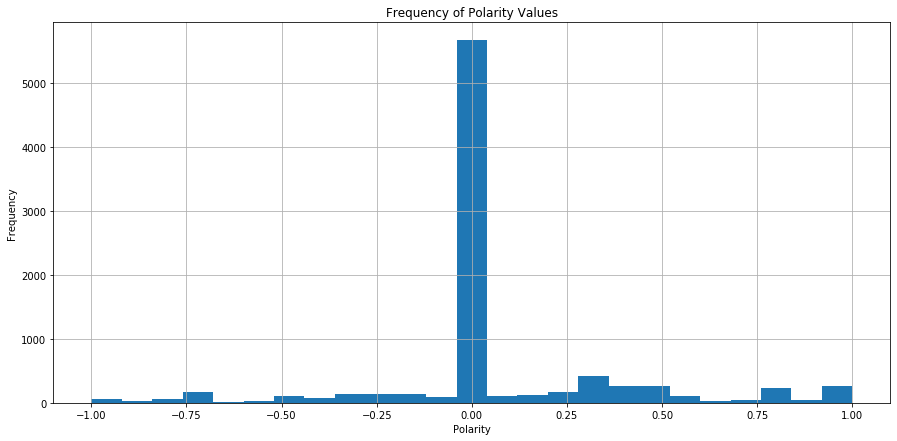

In [513]:
create_polarity_histogram(clean_data)

## Word Cloud Representation of the reviews

We also wanted to look at the types of words we were seeing in the reviews to help trim our stop list down to give more meaningful results.  To get a visual of this, we implemented a word cloud visualization.  We created two separate word clouds - one for positive reviews and one for negative reviews:

### Word Cloud of Positive Review words

In [514]:
def create_positive_word_clouds(clean_data):
    pos_data = clean_data[clean_data.Freshness == 1]
    
    img = WordCloud(width = 600, height = 400,
                          background_color='black', colormap = 'Oranges',
                          stopwords=stop_words,
                          max_words=200,
                          max_font_size=100,
                          random_state=42
                         ).generate(str(pos_data["Review"]))

    plt.figure(figsize=(30,20))
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

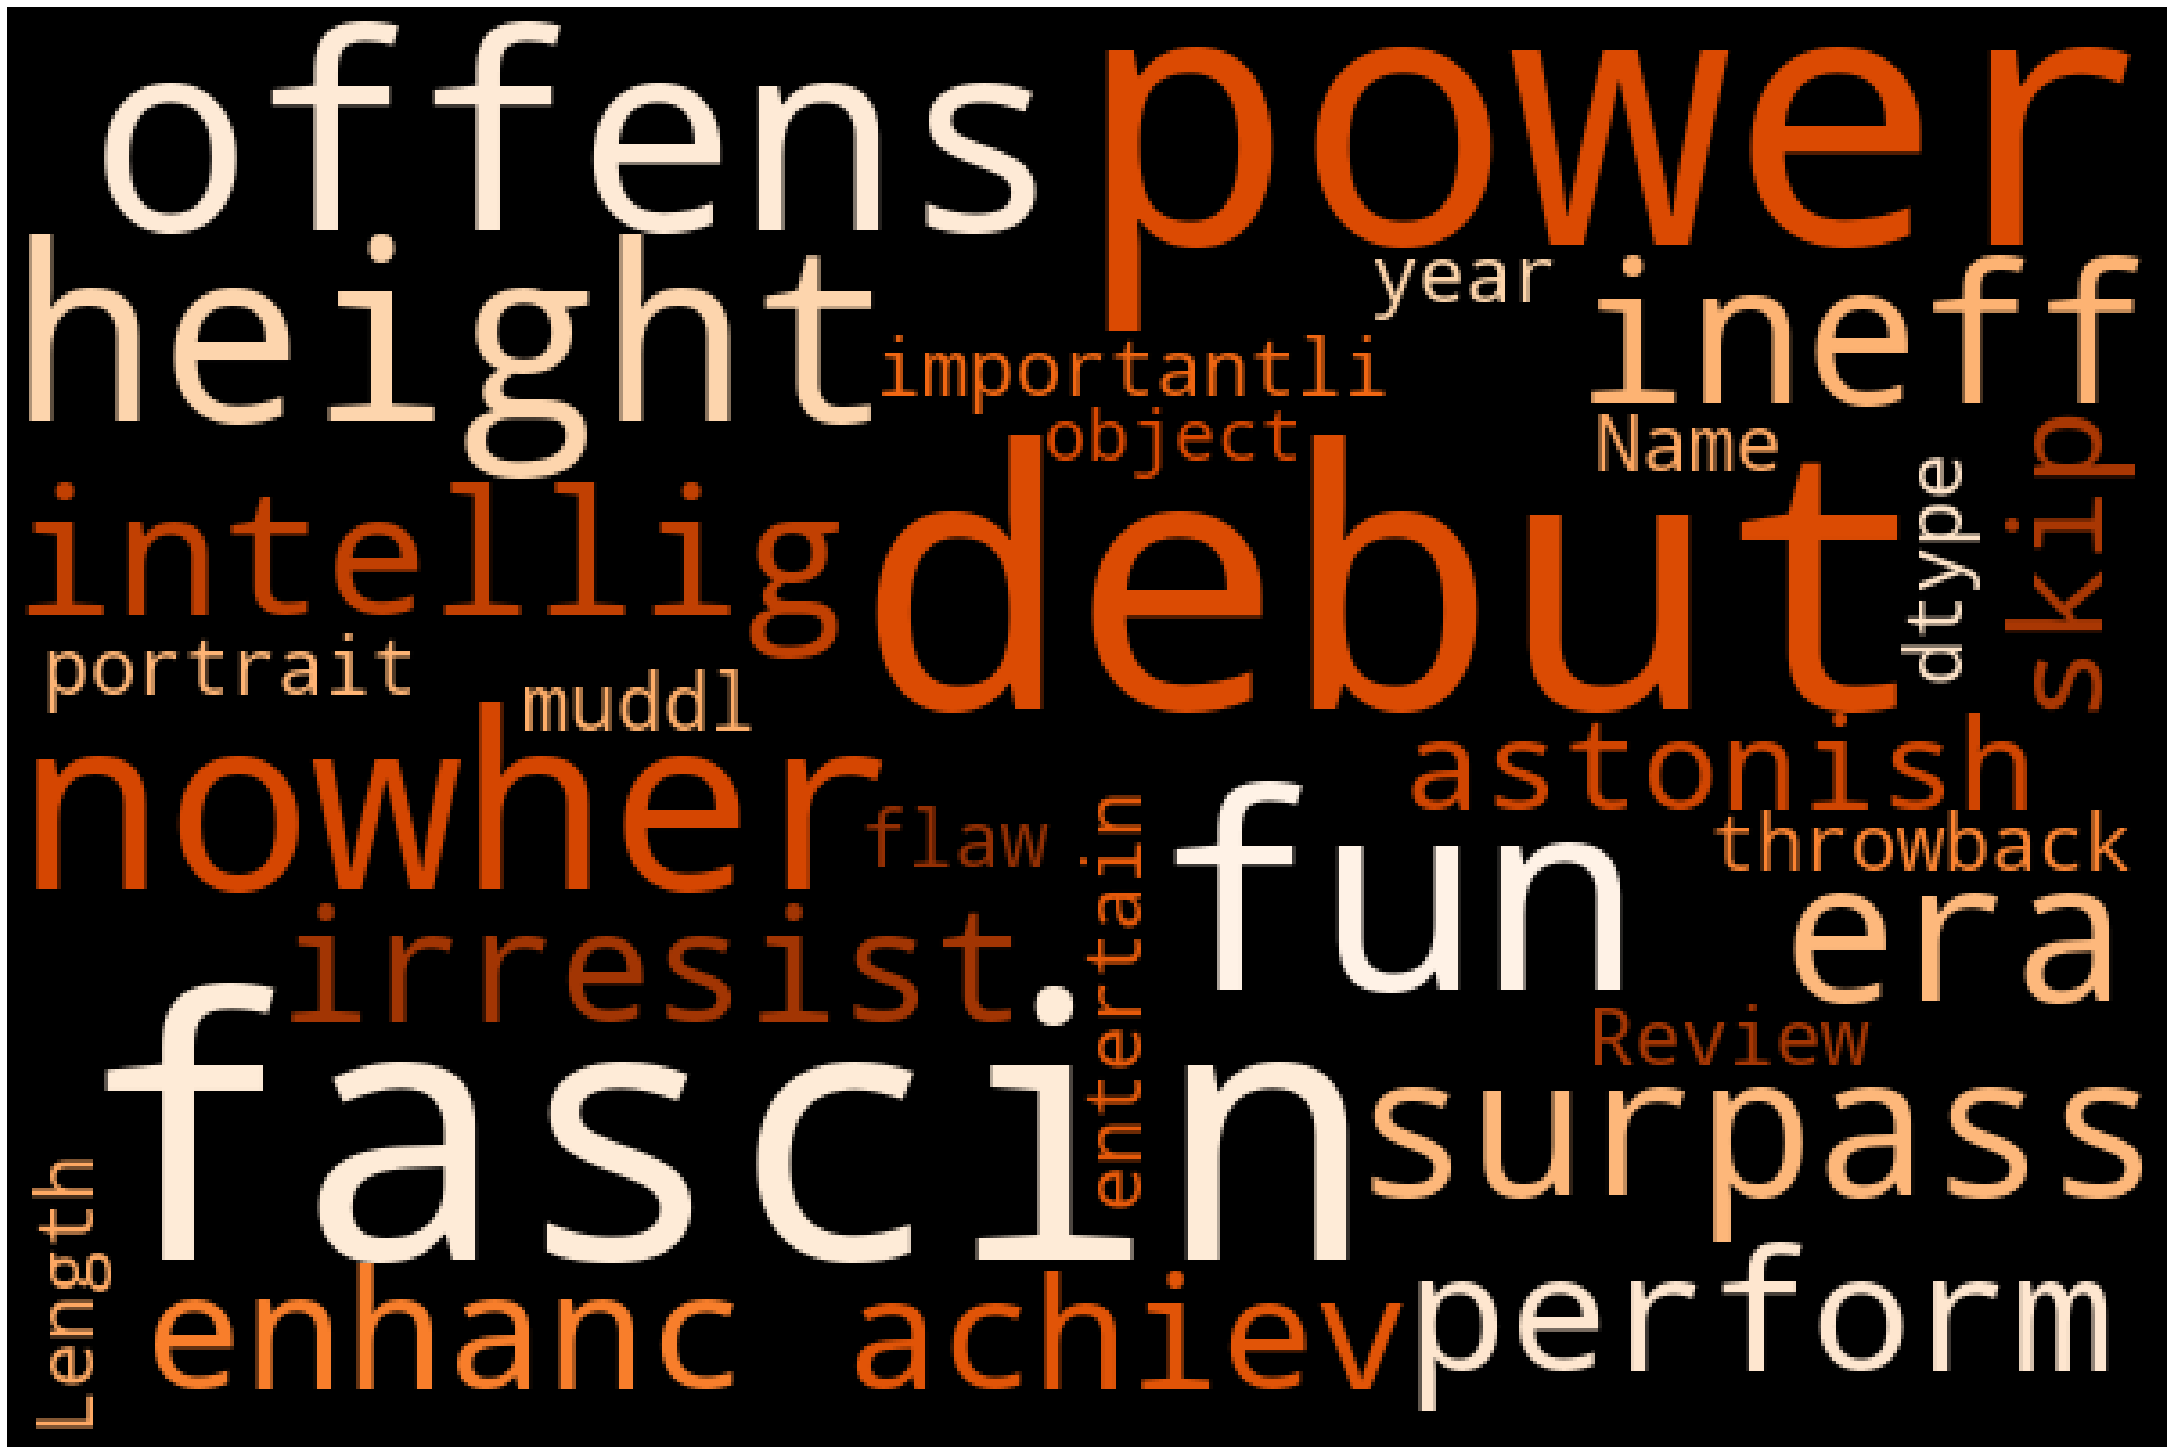

In [515]:
create_positive_word_clouds(clean_data)

### Word Cloud of Negative Review words

In [516]:
def create_negative_word_clouds(clean_data):
    neg_data = clean_data[clean_data.Freshness == 0]
    
    img = WordCloud(width = 600, height = 400,
                          background_color='white', colormap = 'Blues',
                          stopwords=stop_words,
                          max_words=200,
                          max_font_size=100,
                          random_state=42
                         ).generate(str(neg_data["Review"]))

    plt.figure(figsize=(30,20))
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

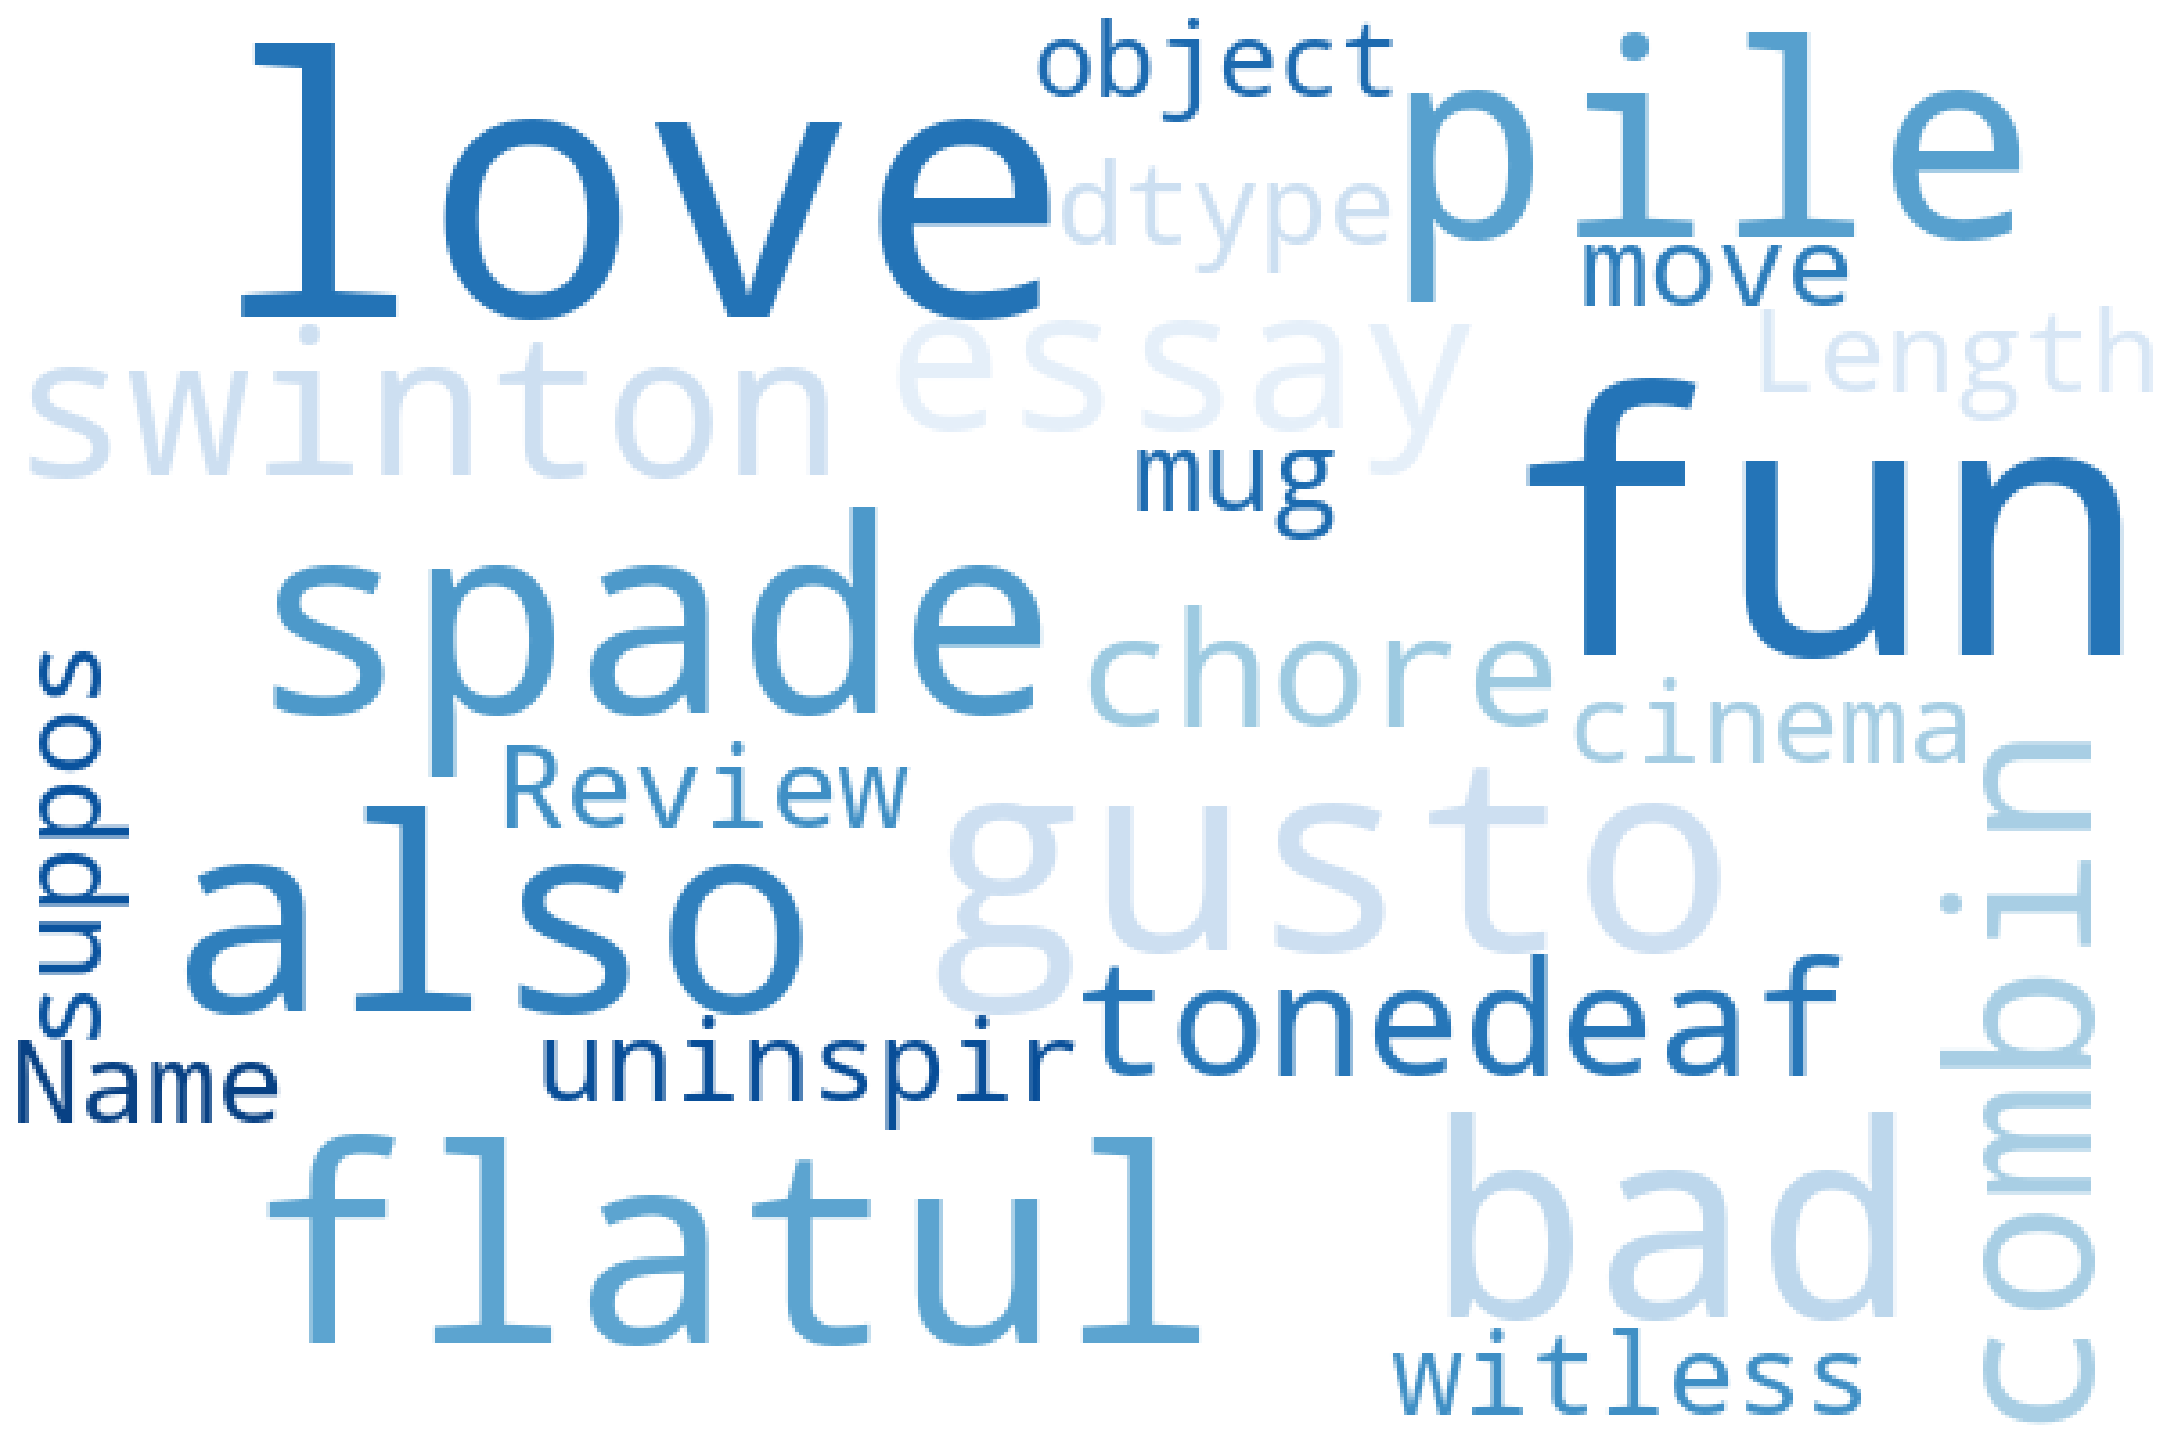

In [517]:
create_negative_word_clouds(clean_data)

### Pie Chart Breakdown of the review types

In [518]:
def create_by_chart(clean_data):
    bkdn = clean_data.groupby("Freshness").Freshness.count()
    bkdn.plot(kind="pie", title="Positve vs Negative Reviews", figsize=(5,5), autopct='%.1f', fontsize=13)
    plt.show()

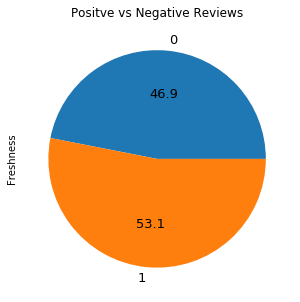

In [519]:
create_by_chart(clean_data)

## Next Steps

- Based on the word clouds, there are additional words we may want to remove from our sample:
    - Twitter tags (i.e. Words starting with @ or # values)
    - Set a max character length to remove words such at yet and add
    - Remove "low value add" words from the model (i.e. A word only appears once or twice in the reviews)
    - Remove Proper nouns such as Person and Movie Names
- Use the vectorized data to train and test the final model
- Create a Topic Model based on the validated reviews
- Create an API and Flask application to allow user input to test against the model
- Build an Interface that will take in a review text, run it against the model and return the Positive/Negative indication

-  And add enough code for extra credit... :)